<a href="https://colab.research.google.com/github/leonSadowski/sc_Hierarchical_Classifier/blob/main/NN_class_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import tensorflow as tf 
import tensorflow.keras as keras 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import networkx as nx

**Create Class for local (NN) classifier**

In [ ]:
class Neural_Network():

  def __init__(self, 
               x_input_data,
               y_input_data,
               z_transform_input = True,
               list_of_hidden_layer_nodes = [30],
               activation_function = 'relu',
               learning_rate = 0.001,
               momentum = .9,
               loss_function = 'categorical_crossentropy',
               epochs = 50):
    
    self.x_input_data = x_input_data
    self.y_input_data = y_input_data
    self.list_of_layer_nodes = [len(self.x_input_data[0])] + [nodes for nodes in list_of_hidden_layer_nodes] + [len(self.y_input_data.cat.categories)] 
    self.activation_function = activation_function 
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.loss_function = loss_function
    self.epochs = epochs
    self.z_transform_input = z_transform_input

    #create model

    self.model = keras.models.Sequential()

    for nodes, layer_idx in zip(self.list_of_layer_nodes, range(0, len(self.list_of_layer_nodes)-1)):

      self.model.add(keras.layers.Dense(
          input_shape = (nodes,),
          units = self.list_of_layer_nodes[layer_idx+1],                            #Ausgabeknotenanzahl == Anzahl Knoten der nächsten Schicht
          kernel_initializer = 'glorot_uniform',                                    #default      
          bias_initializer = 'zeros',                                               #werden die im fit berücksichtigt?
          activation = self.activation_function if layer_idx == 0 else 'softmax'))  #actication als default 'relu', in letzter schicht 'softmax'
        

  def process_input_data(self):

    #z transformation 

    def z_transform_properties(data_arr):
      '''Calculates a z transformation to center properties across cells in data_arr around mean zero'''
      
      mean_vals = np.mean(data_arr, axis=0)
      std_val = np.std(data_arr)

      data_transformed = (data_arr - mean_vals) / std_val

      return data_transformed


    if self.z_transform_input:
      
      self.x_input_data = z_transform_properties(self.x_input_data)

    #converting labels of y_input_data to integers (mapping 'label'->int)

    if isinstance(self.y_input_data, pd.Series):
      #encode categorical labels from pandas Series as integers
      self.label_encoder = LabelEncoder()
      self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data.values)

    elif isinstance(self.y_input_data[0], np.array) and isinstance(self.y_input_data.dtype == int):
      self.y_input_data_int = self.y_input_data

    else:

      print('Error: Invalid or unknown Data Type for Y Input data')

  

    #split data (TO DO: implement scikit.learn cross_val_score for k-fold cross validation)

    split_data_index = int(2/3 * len(self.x_input_data))

    self.x_training_input = self.x_input_data[ : split_data_index]
    self.y_training_input_int = self.y_input_data_int[ : split_data_index]

    self.x_test_input = self.x_input_data[split_data_index : ]
    self.y_test_input_int = self.y_input_data_int[split_data_index : ]

    #use integer y_input data for OneHot Encoding (int -> e_i element R^(int+1)) needed for model training

    self.y_training_onehot = keras.utils.to_categorical(self.y_training_input_int)
    self.y_test_onehot = keras.utils.to_categorical(self.y_test_input_int)


  def train(self):
    '''Train the NN using the x_training_data input and onehot encoded y_training_onehot'''

    self.optimizer = keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum)
    
    self.model.compile(optimizer = self.optimizer, loss = self.loss_function)

    history = self.model.fit(self.x_training_input, self.y_training_onehot,
                        batch_size = 64, epochs = self.epochs, 
                        verbose = 1,
                        validation_split = .1)
    
  def predict(self, input_vec):
    '''Calculate and return label prediction of trained model for an input vector
        input_vec (dtype=int)'''

    pred_vec = np.argmax(self.model.predict(input_vec), axis = -1) #-1?

    return pred_vec


  def validate(self):

    self.y_training_preds = self.predict(self.x_training_input)
    self.y_test_preds = self.predict(self.x_test_input) 

    def calc_acc(pred_vec, known_vec):
      
      if type(pred_vec) == type(known_vec):
        acc = np.sum(pred_vec == known_vec, axis = 0) / len(known_vec)
      else:
        print('self.validate: Error! Comparison of different label encoding!')
      
      return acc

    self.train_acc = calc_acc(self.y_training_preds, self.y_training_input_int) 
    self.test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)


  def local_classifier_output(self):
    '''Evaluate all relevant output of this local classifier
    e.g.:
    self.process_input_data()
    self.train()
    self.validate()'''

    pass

    #missing: potential decoding int->'label', dtype='category'



In [ ]:
class Parent_Node():

#    need attributes: 
#      - input data to local classifier
#      -output vector (predicitions) of following(?) local classifer
#      
#      need methods:
#      - run local calssifier model (best case: generate relevant information for initializing neural network
#      from given list/dict, which defines the subsets, e.g {'TNK':[CD4T, CD8T], etc})

  def __init__(self, x_input_data, y_input_data):
    '''Params:
      - input_data: pd.Series from AnnData Object or np.array,dtype=int -> local classifier will take care of that
    '''

    self.x_input_data = x_input_data
    self.y_input_data = y_input_data

    self.local_classifier = Neural_Network(self.x_input_data, self.y_input_data)

    def run_local_classifier(self):

      self.local_classifier.train()

      #save prediction vector of this local classifier (notice: len(self.children_node_predictions) = #nodes in next level)
      self.children_node_predictions = self.local_classifier.predict(self.local_classifier.x_test_input)

     


#use Parent_Node() objects in hierarchical classifier -> implement network of parent node objects

In [ ]:
class Node_Memory():

  def __init__(self, x_input_data = None, y_input_data = None, local_classifier = None, local_classifier_params = []):

      #local_classifier argument is the Class of classifier (eg Neural_Network (classifier specific params, input and output needed for every possible classifier))
      
      self.x_input_data = x_input_data #processing wird von local classifier übernommen (CAVE bei Verwendung anderer LC (eg SVM), dass preprocessing einheitlich ist)
      self.y_input_data = y_input_data 

      if local_classifier != None:
        self.local_classifier = local_classifier(self.x_input_data, self.y_input_data, *local_classifier_params)
      
      self.noderelevant_input_data_indices = None #save indices of data in input vector, that will be used for prediction in order to compute accuracy
      self.prediction_vec = None

    
  def run_local_classifier(self):

    self.local_classifier.train()
  
  def local_classifier_prediction(self, input_vec): #hier muss noch was passieren, prediction von außen für bestimmte inputs aufrufen

    self.local_classifier.predict(input_vec)

  def subsetting_of_prediction_vector(self):
    pass

In [ ]:
def make_graph_from_edges(d, g, parent_key=''):
    for key in d.keys():
        if parent_key != '':
            g.add_edge(parent_key, key)
        if len(d[key]) == 0:
            pass
        else:
            make_graph_from_edges(d[key], g, parent_key=key)

In [ ]:
class Hierarchical_Classifier():
  '''Class connects Nodes of Local Classifiers, passes results to children classifiers and forms the final hierarchical classifier''' 

  def __init__(self, dict_of_cell_relations):
    '''Params
        - dict_of_cell_relations: used for initializing network structure of hierarchical classifier'''
    self.dict_of_cell_relations = dict_of_cell_relations


  def make_classifier_graph(self):
    '''Compute Graph from a given dictionary of cell relationships'''
    self.graph = nx.DiGraph()
    make_graph_from_edges(self.dict_of_cell_relations, self.graph)

  def init_node_memory_object(self, node, memory_class_params=[]):
    '''Add memory object to each node; memory object organizes all relevant local classifier params'''
    self.graph.add_node(node, memory=Node_Memory(*memory_class_params))

  def subset_pred_vec(self, node):
    next_labels = [label for label in self.graph[node].keys()]
    print(next_labels)
    for next_label in next_labels:
      print('bin in schleife')
      temp_idx_vec = np.where(self.graph.nodes[node]['memory'].prediction_vec == next_label)

      print(self.graph.nodes[node]['memory'].prediction_vec)

      print(temp_idx_vec)
      self.graph.nodes[next_label]['memory'].x_input_data = self.graph.nodes[node]['memory'].x_input_data[temp_idx_vec]



In [ ]:


    # for next_label in next_labels:
    #   print('bin in schleife')
    #   temp_idx_vec = np.where(self.graph.nodes[node]['memory'].prediction_vec == next_label)
    #   self.graph.nodes[next_label]['memory'].x_input_data = self.graph.nodes[node]['memory'].x_input_data[temp_idx_vec]

In [ ]:
    '''in methode subset_pred_vec:'''
    # return next_labels

    # damit for schleife für wirkliche pred_vec's funktioniert (insb der temp_idx_vec) muss die liste it ints mit dem decoder wieder in 
    # string labels umgeschrieben werden !

'in methode subset_pred_vec:'

In [ ]:


  # def subset_pred_vec(self, node):
  #   '''Method of HC in order to have access to labels of neighboring nodes of one node -> automatic subsetting
  #      Requires already initialized memory attribute, which is given in case that the classifier has already been run'''

  #   neighbor_labels = [key for key in self.graph[node].keys()] 

  #   return neighbor_labels


  


**#######################################################**
**Messy Test bereich**

In [ ]:
hc = Hierarchical_Classifier({'all': {'tnk':{'cd4t':{}, 'cd8t':{}}, 'm':{'cd17':{}, 'fc':{}}}})

In [ ]:
hc.make_classifier_graph()

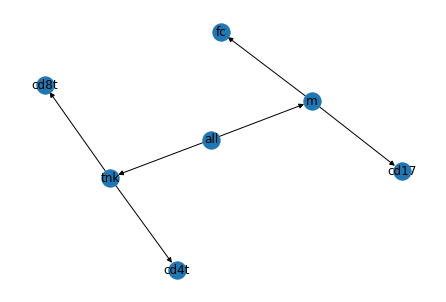

In [ ]:
nx.draw(hc.graph, with_labels=True)

In [ ]:
hc.init_node_memory_object('all')

In [ ]:
for node in hc.graph.nodes:
  hc.init_node_memory_object(node)

In [ ]:
hc.graph.nodes.data()

NodeDataView({'all': {'memory': <__main__.Node_Memory object at 0x7f0f47fb76d0>}, 'tnk': {'memory': <__main__.Node_Memory object at 0x7f0f47e58e50>}, 'cd4t': {'memory': <__main__.Node_Memory object at 0x7f0f47e58990>}, 'cd8t': {'memory': <__main__.Node_Memory object at 0x7f0f47e58450>}, 'm': {'memory': <__main__.Node_Memory object at 0x7f0f47e58a90>}, 'cd17': {'memory': <__main__.Node_Memory object at 0x7f0f47e58410>}, 'fc': {'memory': <__main__.Node_Memory object at 0x7f0f47e58610>}})

In [ ]:
#Syntax erlaubt zugriff auf attribute des memory ojekts von node 'all'
hc.graph.nodes['all']['memory'].prediction_vec

In [ ]:
prediction_vec = ['tnk', 'm', 'm', 'm', 'tnk','tnk', 'm', 'tnk']

In [ ]:
prediction_vec

In [ ]:
#Test der Hierarchical_Classifier.subset_pred_vec Methode 


#assign made up pred vec to node 'all'
hc.graph.nodes['all']['memory'].prediction_vec = ['tnk', 'm', 'm', 'm', 'tnk','tnk', 'm', 'tnk']

#assign made up input data to 'all' node, from which daughter nodes will be subsetting 
hc.graph.nodes['all']['memory'].x_input_data = [[0,0,0], [1,1,1], [2,2,2], [3,3,3], [4,4,4], [5,5,5], [6,6,6], [7,7,7]]


['tnk', 'm', 'm', 'm', 'tnk', 'tnk', 'm', 'tnk']


In [ ]:
print(np.array(hc.graph.nodes['all']['memory'].prediction_vec))

next_labels = [label for label in hc.graph['all'].keys()]
print(next_labels[0])
idx_vec = np.where(np.array(hc.graph.nodes['all']['memory'].prediction_vec) == next_labels[0])
print(idx_vec)

['tnk' 'm' 'm' 'm' 'tnk' 'tnk' 'm' 'tnk']
tnk
(array([0, 4, 5, 7]),)


In [ ]:

hc.subset_pred_vec('all')

In [ ]:
#ausgabe der subsetted input vektoren der nachfolgenden knoten 
# print(f'generierte x_input_data für tnk node: {hc.graph.nodes['tnk']['memory'].x_input_data}')
# print(f'generierte x_input_data für m node: {hc.graph.nodes['m']['memory'].x_input_data}')

print(hc.graph.nodes['tnk']['memory'].x_input_data)
print(hc.graph.nodes['m']['memory'].x_input_data)

None
None


In [ ]:
print(hc.subset_pred_vec('tnk'))

['cd4t', 'cd8t']


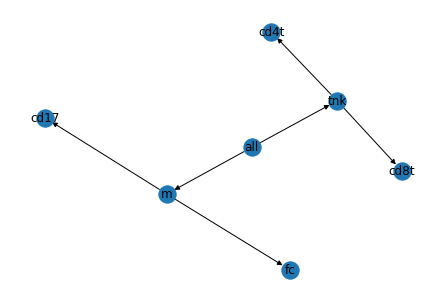

In [ ]:
nx.draw(hc.graph, with_labels=True)

**Test of Local classifier class**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install scanpy 


     |████████████████████████████████| 2.0 MB 7.4 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 96 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=47f201506fe5495f56bf8599397ee12873da85441f673c64ea6b2d9c7d8b5603
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=e25d3a2e521d7dfd912f9f1defff5964b21cc9490731b9ef07099522a04a42be
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=c98ee6d9ed9dc6099aed94e28edda1598630af7b72626d88cbccd4fa5bc3e7e0
  Stored in directory: /root/.cache/pi

In [ ]:
import scanpy as sc

In [ ]:
adata = sc.read('drive/MyDrive/single_cell/processed/pbmc3k_level_1_scvi.h5ad')

X_input, y_input = adata.obsm['X_scVI'], adata.obs['training_level_1']

# print(f'y_input: {y_input}' )

# print(f'\n\n*******************\n {len(y_input.cat.categories)}')

nn_tnk = Neural_Network(X_input, y_input, epochs = 200)

nn_tnk.model.summary()

# nn_tnk.local_classifier_output()
nn_tnk.process_input_data()
nn_tnk.train()

# nn_tnk.predict(nn_tnk.x_training_input)

nn_tnk.validate()

print(f'training_acc: {nn_tnk.train_acc:42f}')

print(f'test_acc: {nn_tnk.test_acc:.4f}')




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                330       
                                                                 
 dense_1 (Dense)             (None, 4)                 124       
                                                                 
Total params: 454
Trainable params: 454
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 1.5349 - val_loss: 1.3964
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 1.2436 - val_loss: 1.1240
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 1.0263 - val_loss: 0.9539
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 0.8885 - val_loss: 0.8460
Epoch 5/200
25/25 [==============================] - 0s 4m